In [1]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#16a085', '#e8f6f3', '#d0ece7', '#a2d9ce', '#73c6b6', '#45b39d', 
                        '#16a085', '#138d75', '#117a65', '#0e6655', '#0b5345']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 

In [2]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=AILab-MLTools&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [3]:
%%capture
!pip3 install -U lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip3 install -U pandas

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [4]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# For NN training
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.preprocessing import StandardScaler

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [5]:
N_THREADS = 4
N_FOLDS = 15
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 8 * 3600 # equal to 8 hours
TARGET_NAME = 'target'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [7]:
INPUT_DIR = '../input/tabular-playground-series-may-2022/'

In [8]:
train_data = pd.read_csv(INPUT_DIR + 'train.csv')
print(train_data.shape)
train_data.head()

(900000, 33)


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [9]:
test_data = pd.read_csv(INPUT_DIR + 'test.csv')
print(test_data.shape)
test_data.head()

(700000, 32)


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,...,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,...,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,...,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
3,900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,...,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
4,900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,...,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


In [10]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(700000, 2)


,id,target
0,900000,0.5
1,900001,0.5
2,900002,0.5
3,900003,0.5
4,900004,0.5


### 0.5. Feature engineering
Let's prepare some features from the text feature `f_27` and top importance features compositions:

In [11]:
def create_tf_idf_feats(corpus, ngram_range = (1, 1), max_features = None):
    vectorizer = TfidfVectorizer(analyzer = 'char', lowercase = False, 
                                 ngram_range = ngram_range, max_features = max_features)
    X = vectorizer.fit_transform(corpus).todense()
    char_mapper = {y:x for x, y in vectorizer.vocabulary_.items()}
    column_names = ['tfidf_{}'.format(char_mapper[i]) for i in range(len(char_mapper))]
    return pd.DataFrame(X, columns = column_names)

# Create all texts array
all_texts = pd.concat([train_data[['f_27']], test_data[['f_27']]]).reset_index(drop = True)
# corpus = all_texts['f_27'].values

# Calculate TF-IDF features for unigrams and top-20 bigrams
# all_texts = pd.concat([all_texts, 
#                       create_tf_idf_feats(corpus),
#                       create_tf_idf_feats(corpus, (2,2), 20)], axis = 1)

# Create features for unique characters
for i in range(10):
    all_texts[f'char_{i}'] = all_texts['f_27'].str.get(i).map(ord) - ord('A')
    
# How many unique characters are in each text?
all_texts['unique_chars_cnt'] = all_texts['f_27'].map(lambda x: len(set(x)))

# How often the text occurs in the whole dataset
all_texts['value_frequency'] = all_texts['f_27'].map(all_texts['f_27'].value_counts() / len(all_texts))

all_texts.drop(columns = ['f_27'], inplace = True)

In [12]:
all_texts.head()

,char_0,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,unique_chars_cnt,value_frequency
0,0,1,0,1,3,0,3,1,0,1,3,1.875000e-06
1,0,2,0,2,2,0,3,2,4,1,5,1.250000e-06
2,0,0,0,4,0,1,2,10,0,3,6,1.250000e-06
3,1,3,1,1,0,0,2,1,2,1,4,3.125000e-06
4,1,3,1,2,1,1,2,7,5,4,6,6.250000e-07


In [13]:
train_data = pd.concat([train_data,
                       all_texts.iloc[:len(train_data), :]], axis = 1)
test_data = pd.concat([test_data,
                       all_texts.iloc[len(train_data):, :].reset_index(drop = True)], axis = 1)

print(train_data.shape, test_data.shape)

(900000, 45) (700000, 44)


In [14]:
train_data.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,unique_chars_cnt,value_frequency
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,0,1,3,0,3,1,0,1,3,1.875000e-06
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,0,2,2,0,3,2,4,1,5,1.250000e-06
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,0,4,0,1,2,10,0,3,6,1.250000e-06
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,1,1,0,0,2,1,2,1,4,3.125000e-06
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,1,2,1,1,2,7,5,4,6,6.250000e-07


In [15]:
del all_texts

In [16]:
for data in [train_data, test_data]:
    for i,j in [(26, 21), (26, 22), (21, 22), (26, 30), (26, 25),
               (22, 30), (22, 25), (21, 30), (21, 25), (30, 25)]:
        data['f_{}_plus_f_{}'.format(i, j)] = data['f_{}'.format(i)] + data['f_{}'.format(j)]
        data['f_{}_minus_f_{}'.format(i, j)] = data['f_{}'.format(i)] - data['f_{}'.format(j)]

#### Features from the next cell are from [great notebook](https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras) by @Ambrosm - please upvote it first 👍

In [17]:
for data in [train_data, test_data]:
    data['comb_02_21'] = data['f_21'] + data['f_02']
    data['comb_02_21_i'] = (data['comb_02_21'] > 5.2).astype(int) - (data['comb_02_21'] < -5.3).astype(int)
    
    data['comb_05_22'] = data['f_22'] + data['f_05']
    data['comb_05_22_i'] = (data['comb_05_22'] > 5.1).astype(int) - (data['comb_05_22'] < -5.4).astype(int)
    
    data['comb_00_01_26'] = data['f_00'] + data['f_01'] + data['f_26']
    data['comb_00_01_26_i'] = (data['comb_00_01_26'] > 5.0).astype(int) - (data['comb_00_01_26'] < -5.0).astype(int)

In [18]:
train_data.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21_plus_f_25,f_21_minus_f_25,f_30_plus_f_25,f_30_minus_f_25,comb_02_21,comb_02_21_i,comb_05_22,comb_05_22_i,comb_00_01_26,comb_00_01_26_i
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,2.850363,3.266718,-0.208177,0.208177,2.815165,0,-1.701412,0,0.229043,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,-1.603144,5.961244,-3.782194,3.782194,-0.051282,0,0.726140,0,-0.071618,0
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,2.004301,-3.572771,4.788536,-0.788536,-1.811924,0,-1.271810,0,-1.405017,0
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,-4.876917,0.189279,-2.533098,2.533098,-3.148456,0,0.443763,0,-1.314607,0
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-2.173119,4.440450,-2.306784,4.306784,0.468794,0,-3.412812,0,5.343286,1


In [19]:
#print([col for col in train_data.columns if col.startswith('tfidf_')])

### 0.6. Dense neural net probabilities
As the data is created from GAN, which is neural network, let's use simple neural network to get these dependencies from the data:

In [20]:
def nn_model(n_feats):
    inputs = Input(shape=(n_feats))
    x = Dense(64, activation='swish')(inputs)
    #x = Dropout(0.1)(x)
    x = Dense(64, activation='swish')(x)
    #x = Dropout(0.1)(x)
    x = Dense(16, activation='swish')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, x)
    return model


def fit_model(X_train, y_train, 
              X_valid, y_valid, 
              X_test):
    
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_train)
    X_va = scaler.transform(X_valid)
    X_te = scaler.transform(X_test)
    valid_data = (X_va, y_valid)

    lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.75, 
                           patience = 10, verbose = 0)
    es = EarlyStopping(monitor = "val_loss", patience = 20, 
                       verbose = 1, restore_best_weights = True)
    model = nn_model(X_train.shape[1])
    model.compile(optimizer = Adam(learning_rate = 0.01),
                  loss = BinaryCrossentropy())

    history = model.fit(X_tr, y_train, 
                        validation_data = valid_data, 
                        epochs = 500,
                        verbose = 0,
                        batch_size = 4096,
                        shuffle = True,
                        callbacks = [lr, es])
    
    y_valid_pred = model.predict(X_va).reshape(1, -1)[0]
    y_test_pred = model.predict(X_te).reshape(1, -1)[0]

    return y_valid_pred, y_test_pred


features = [x for x in train_data.columns if x not in ['id', TARGET_NAME, 'f_27']]
skf = StratifiedKFold(n_splits = N_FOLDS, random_state = RANDOM_STATE, shuffle = True)
NN_OOF_PRED = np.zeros(len(train_data))
NN_TEST_PRED = np.zeros(len(test_data))
    
y = train_data[TARGET_NAME].values
X_test = test_data[features]
N_START = 9
for it in range(N_START):
    for fold, (train_idx, valid_idx) in enumerate(skf.split(y, y)):
        X_train = train_data.iloc[train_idx, :][features]
        X_valid = train_data.iloc[valid_idx, :][features]
        y_train = y[train_idx]
        y_valid = y[valid_idx]

        val_pred, test_pred = fit_model(X_train, y_train, 
                                        X_valid, y_valid, 
                                        X_test)

        print('ITER = {} FOLD {} score {:.5f}'.format(it, fold, roc_auc_score(y_valid, val_pred)))

        NN_OOF_PRED[valid_idx] += val_pred / N_START
        NN_TEST_PRED += test_pred / N_FOLDS / N_START
    print('AFTER ITER {} NN OOF score {:.5f}'.format(it, roc_auc_score(y, NN_OOF_PRED)))
    
print('NN OOF score {:.5f}'.format(roc_auc_score(y, NN_OOF_PRED)))

2022-05-12 10:38:41.114367: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-12 10:38:41.795265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
ITER = 0 FOLD 0 score 0.99736
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
ITER = 0 FOLD 1 score 0.99748
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
ITER = 0 FOLD 2 score 0.99748
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
ITER = 0 FOLD 3 score 0.99730
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
ITER = 0 FOLD 4 score 0.99749
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
ITER = 0 FOLD 5 score 0.99730
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
ITER = 0 FOLD 6 score 0.99725
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
ITER = 0 FOLD 7 score 0.99751
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
ITER

In [21]:
train_data['NN'] = NN_OOF_PRED
test_data['NN'] = NN_TEST_PRED

In [22]:
oofs = train_data[['id']]
oofs[TARGET_NAME] = NN_OOF_PRED
oofs.to_csv('oof_nn_preds_only.csv', index = False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
submission[TARGET_NAME] = NN_TEST_PRED
submission.to_csv('nn_preds_only.csv', index = False)

# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [24]:
task = Task('binary',)

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [25]:
roles = {
    'target': TARGET_NAME,
    'drop': ['id', 'f_27'] #+ [col for col in train_data.columns if col.startswith('tfidf_')]
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [26]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    general_params = {'use_algos': [['lgb']]},
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [27]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 3)

[17:19:38] Stdout logging level is INFO3.
[17:19:38] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[17:19:38] Task: binary

[17:19:38] Start automl preset with listed constraints:
[17:19:38] - time: 28800.00 seconds
[17:19:38] - CPU: 4 cores
[17:19:38] - memory: 16 GB

[17:19:38] Train data shape: (900000, 72)

[17:19:53] Feats was rejected during automatic roles guess: []
[17:19:53] Layer 1 train process start. Time left 28784.80 secs
[17:19:57] [1]	valid's auc: 0.997209
[17:19:57] Training until validation scores don't improve for 100 rounds
[17:20:17] [100]	valid's auc: 0.99794
[17:20:42] [200]	valid's auc: 0.997878
[17:20:52] Selector_LightGBM fitting and predicting completed
[17:20:53] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[17:20:54] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[17:20:57] [1]	valid's auc: 0.873374
[17:20:57] Training until validation scores don't improve for 100 rounds
[17:21:17]

In [28]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (15 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 


In [29]:
print(f'TRAIN out-of-fold score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

TRAIN out-of-fold score: 0.9980038571041226


# 3. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: user 583 ms, sys: 0 ns, total: 583 ms
Wall time: 226 ms


<AxesSubplot:xlabel='Feature'>

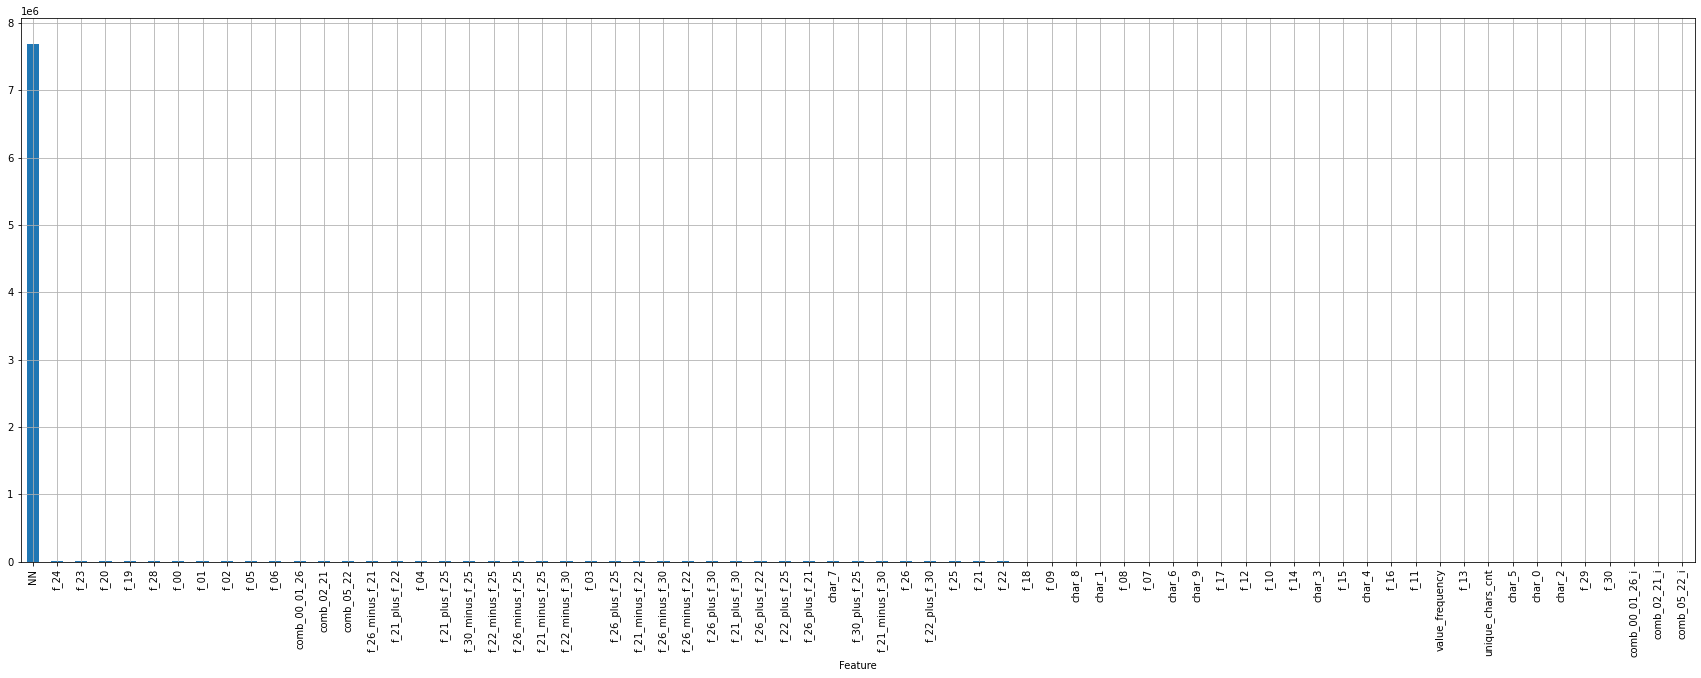

In [30]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
top_5_features = fast_fi['Feature'].values[:5]
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [31]:
fast_fi.head()

,Feature,Importance
0,NN,7.688438e+06
1,f_24,8.225547e+03
2,f_23,8.166328e+03
3,f_20,8.007767e+03
4,f_19,7.505094e+03


100%|██████████| 30/30 [00:45<00:00,  1.53s/it]


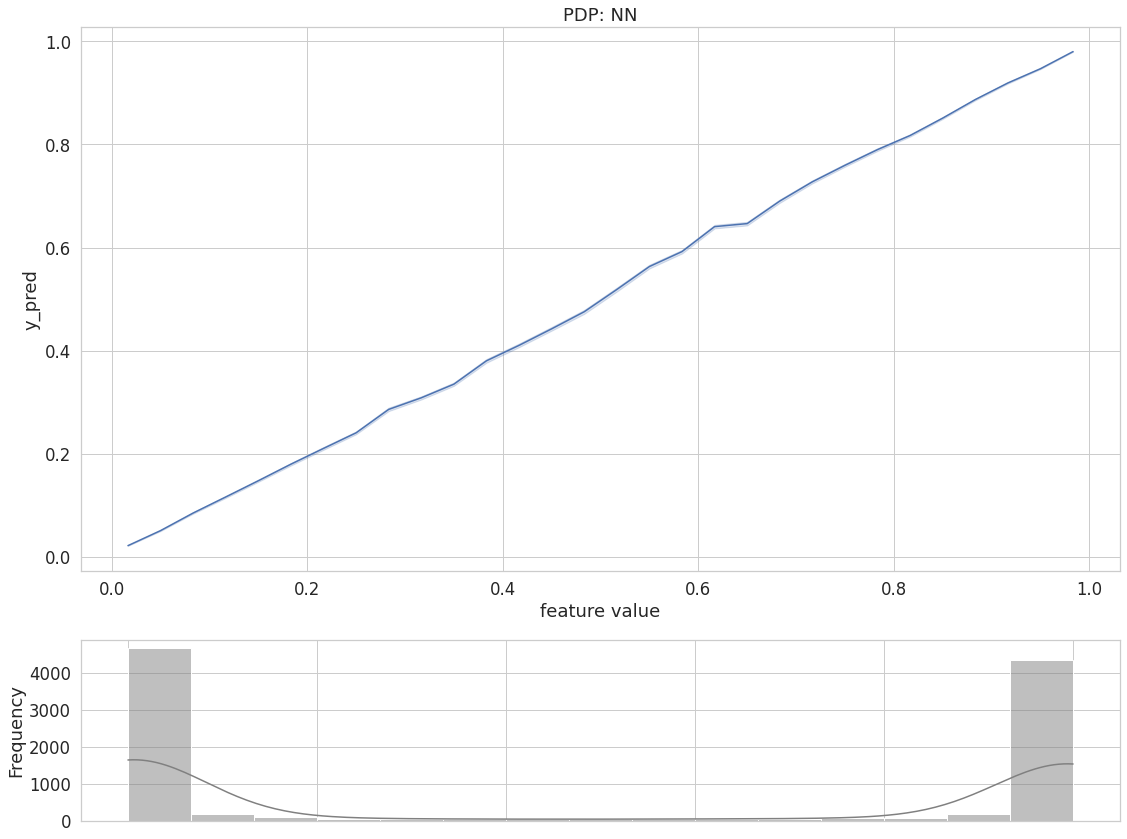

In [32]:
automl.plot_pdp(test_data.sample(10000), feature_name=top_5_features[0])

100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


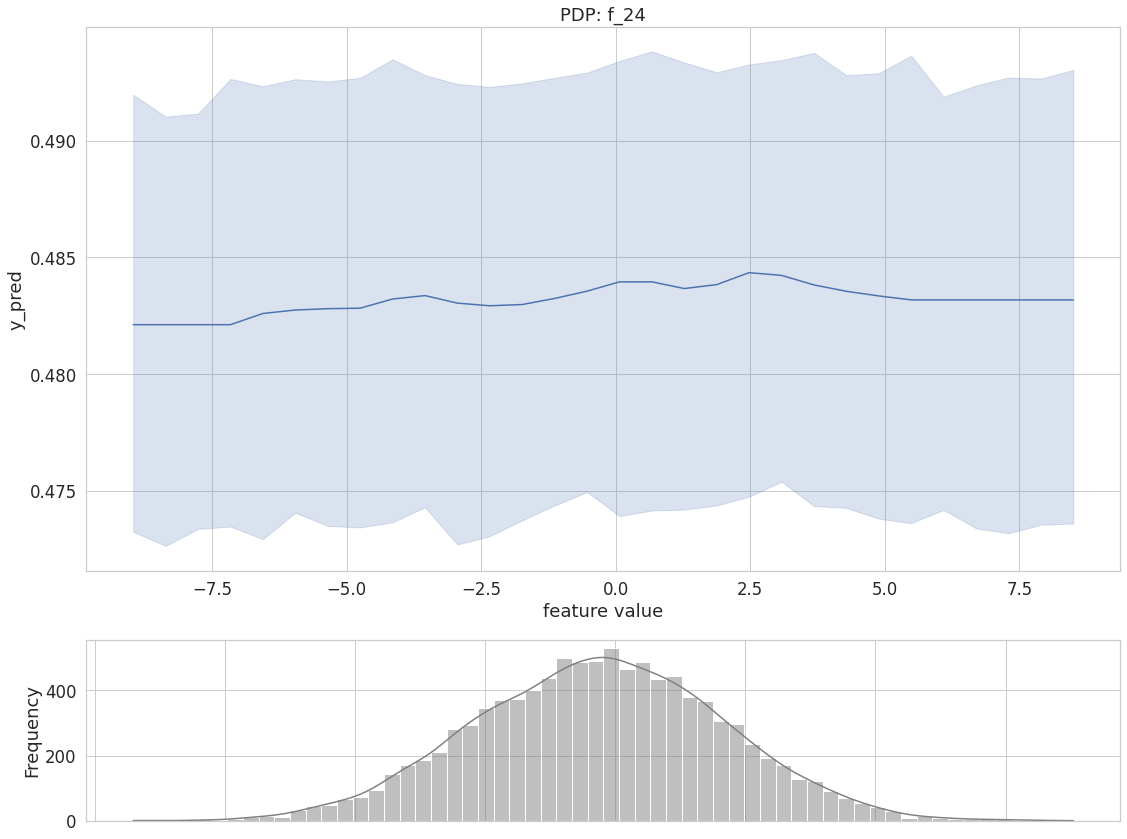

In [33]:
automl.plot_pdp(test_data.sample(10000), feature_name=top_5_features[1])

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


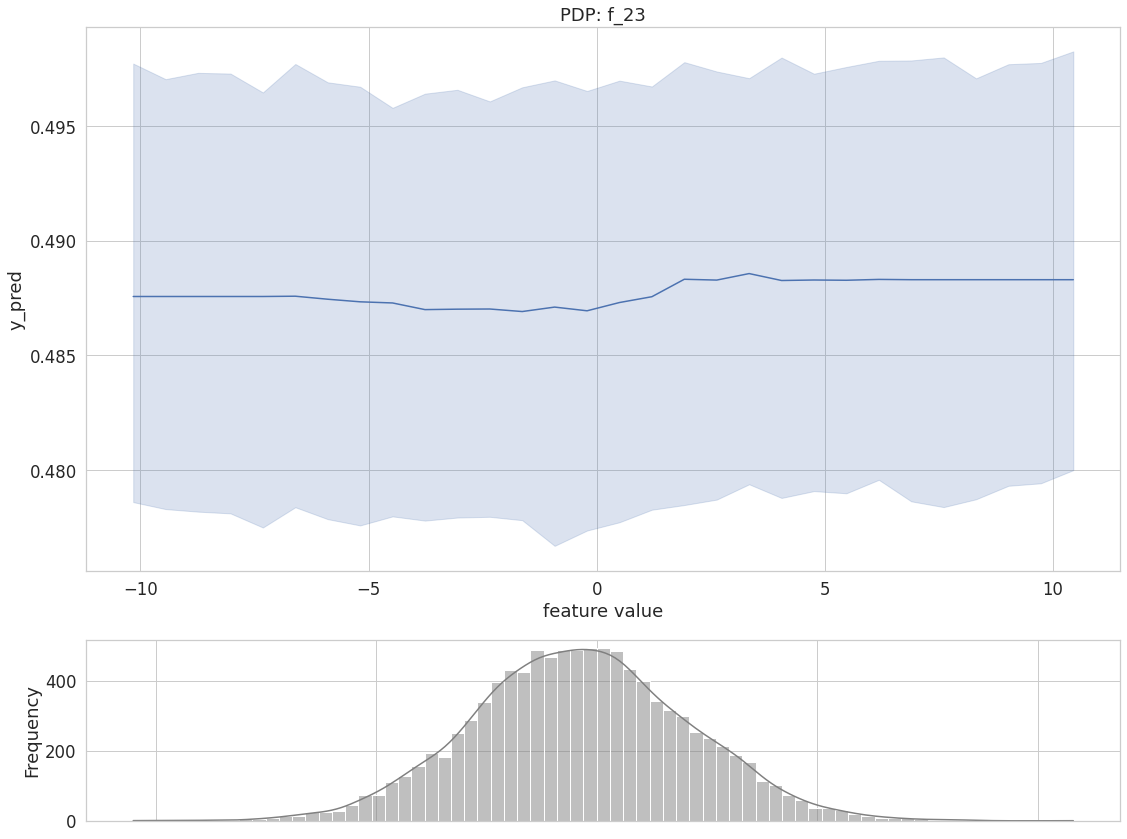

In [34]:
automl.plot_pdp(test_data.sample(10000), feature_name=top_5_features[2])

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


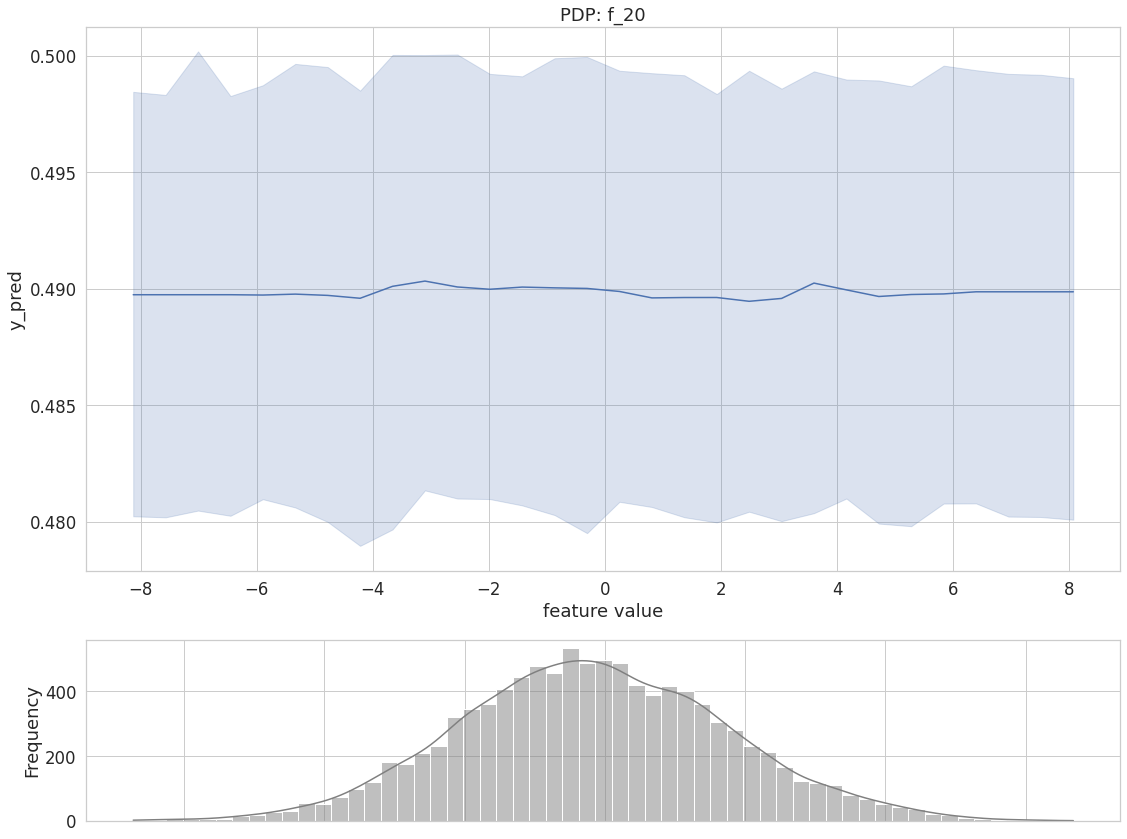

In [35]:
automl.plot_pdp(test_data.sample(10000), feature_name=top_5_features[3])

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


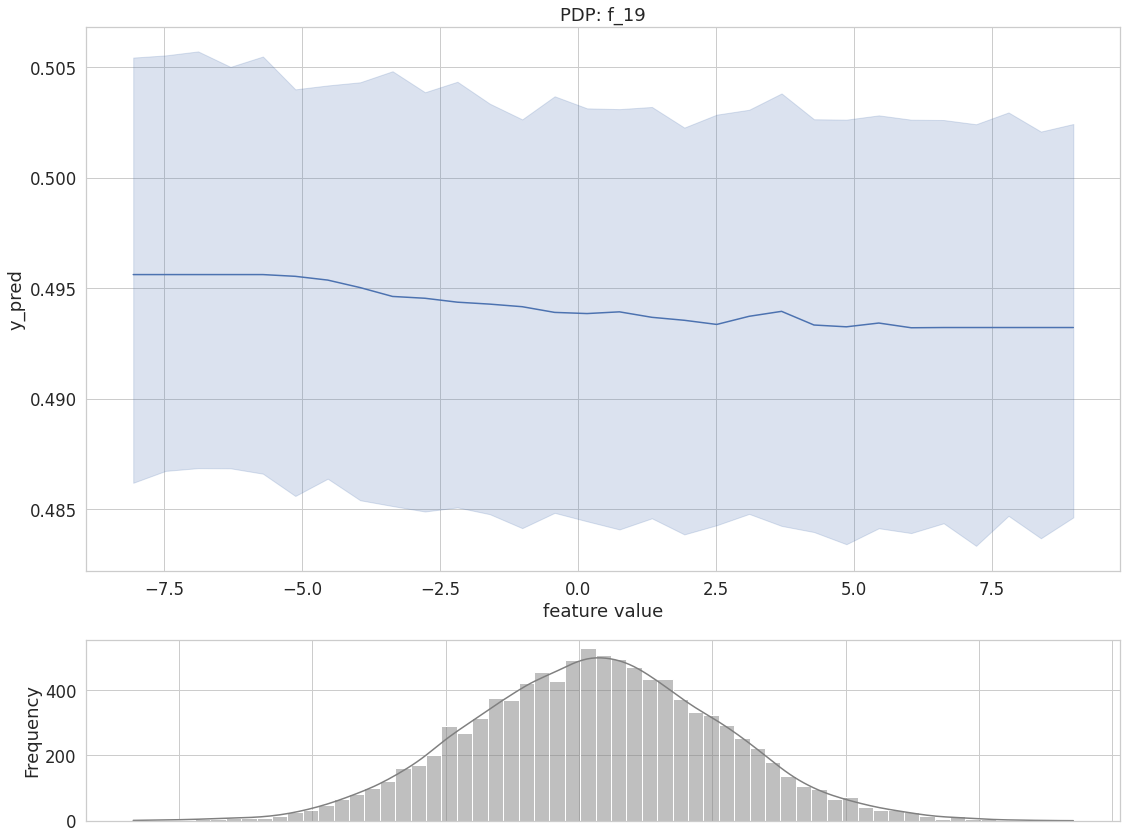

In [36]:
automl.plot_pdp(test_data.sample(10000), feature_name=top_5_features[4])

In [37]:
#%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 4. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [38]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[9.9973917e-01],
       [9.9906689e-01],
       [2.4179483e-04],
       ...,
       [3.1672381e-02],
       [3.1315067e-04],
       [2.5681406e-04]], dtype=float32)
Shape = (700000, 1)


In [39]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('lightautoml_tabularautoml.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

In [40]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=AILab-MLTools&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
